{% include toc title="In This Chapter" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-ship" aria-hidden="true"></i> Chapter Six - Uncertainty in Remote Sensing Data

In this chapter, you will integrate vector and raster data using **Python** to explore uncertainty in scientific analyses.


## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

After completing this chapter, you will be able to:

* List and describe at least 3 sources of uncertainty / error associated with remote sensing data.
* Interpret a scatter plot that compares remote sensing values with field measured values to determine how "well" the two metrics compare.
* Use the `rasterstats.zonal_stats()` function to extract raster pixel values using a vector extent or set of extents.
* Create a scatter plot with a one to one line in **Python** using **matplotlib**.
* Merge two dataframes in **Python**.
* Perform a basic least squares linear regression analysis on two variables of interest in **Python**.
* Analyze regression outputs to determine the strength of the relatonship between two variables.
* Define `R-squared` and `p-value` as it relates to regression.

## <i class="fa fa-check-square-o fa-2" aria-hidden="true"></i> What You Need

You will need a computer with internet access to complete this lesson. You will also need the data you downloaded for last week of this class: `spatial-vector-lidar data` subset. 

{% include/data_subsets/course_earth_analytics/_data-spatial-lidar.md %}

</div>


## Understand Uncertainty and Error

It is important to consider error and uncertainty when presenting scientific
results. Most measurements that we make - be they from instruments or humans -
have uncertainty associated with them. We will discuss what
that means, below.

## Uncertainty

**Uncertainty:** Uncertainty quantifies the range of values within which the
value of the measure falls within - within a specified level of confidence. The
uncertainty quantitatively indicates the "quality" of your measurement. It
answers the question: "how well does the result represent the value of the
quantity being measured?"

### Tree Height Measurement Example

So for example let's pretend that we measured the height of a tree 10 times. Each
time our tree height measurement may be slightly different? Why? Because maybe
each time we visually determined the top of the tree to be in a slightly different
place. Or maybe there was wind that day during measurements that
caused the tree to shift as we measured it yielding a slightly different height
each time. or... what other reasons can you think of that might impact tree height
measurements?

<figure>
   <a href="{{ site.url }}/images/earth-analytics/lidar-raster-data/measuring-tree-height.jpg">
   <img src="{{ site.url }}/images/earth-analytics/lidar-raster-data/measuring-tree-height.jpg" alt="When we measure tree height by hand, many different variables may impact the accuracy and precision of our results."></a>
   <figcaption>When we measure tree height by hand, many different variables may impact the accuracy and precision of our results. Source:  http://www.haddenham.net/newsroom/guess-tree-height.html
   </figcaption>
</figure>

## What is the True Value?

So you may be wondering, what is the true height of our tree?
In the case of a tree in a forest, it's very difficult to determine the
true height. So we accept that there will be some variation in our measurements
and we measure the tree over and over again until we understand the range of
heights that we are likely to get when we measure the tree.


In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import rioxarray as rxr
from rasterio.plot import plotting_extent
import rasterstats as rs
import contextily as cx
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Supress warnings
warnings.simplefilter('ignore')

# Setting consistent plotting style throughout notebook
sns.set_style("white")
sns.set(font_scale=1.5)

data = et.data.get_data("spatial-vector-lidar",
                        verbose=False)

os.chdir(os.path.join(et.io.HOME,
                      "earth-analytics",
                      "data"))

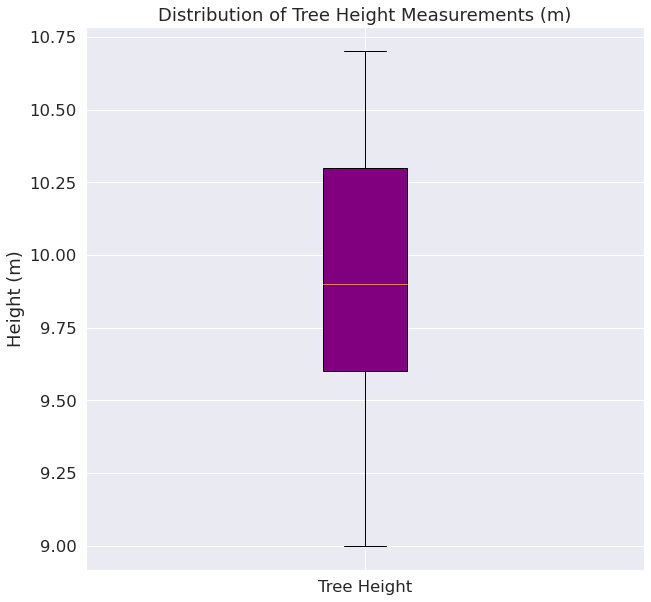

In [2]:
# Create a data.frame of tree heights
tree_heights = pd.DataFrame([10, 10.1, 9, 9.1, 9.9, 9.5, 9.7,
                             9.8, 9.6, 10.5, 10.7, 10.3, 10.6],
                            columns=['heights'])

# What is the average tree height
# print(tree_heights.mean(0))

# What is the standard deviation of measurements?
# print(tree_heights.std())

# Make a boxplot of the data
fig, ax = plt.subplots(figsize=(10, 10))
bp = ax.boxplot(tree_heights.heights,
                patch_artist=True,
                labels=["Tree Height"])
ax.set(title="Distribution of Tree Height Measurements (m)",
       ylabel="Height (m)")
bp['boxes'][0].set_facecolor('purple')
plt.show()

In the example above, the mean tree height value is towards the center of
the distribution of measured heights. You might expect that the sample mean of
our observations provides a reasonable estimate of the true value. The
variation among our measured values may also provide some information about the
precision (or lack thereof) of the measurement process.

<a href="http://www.physics.csbsju.edu/stats/box2.html" target="_blank">Read more about the what a box plots tells you about data.</a>

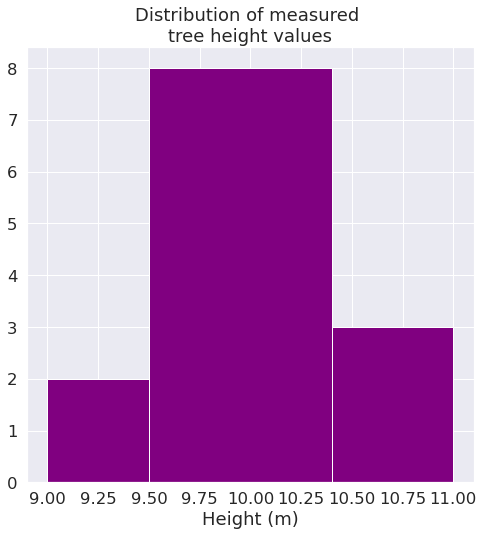

In [3]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.hist(tree_heights.heights,
        bins=[9, 9.5, 10.4, 11], color='purple', edgecolor='white')
ax.set(title="Distribution of measured \ntree height values",
       xlabel="Height (m)")
plt.show()

## Measurement Accuracy

Measurement **accuracy** is a concept that relates to whether there is bias in
measurements, i.e. whether the expected value of our observations is close to
the true value. For low accuracy measurements, we may collect many observations,
and the mean of those observations may not provide a good measure of the truth
(e.g., the height of the tree). For high accuracy measurements, the mean of
many observations would provide a good measure of the true value. This is
different from **precision**, which typically refers to the variation among
observations. Accuracy and precision are not always tightly coupled. It is
possible to have measurements that are very precise but inaccurate, very
imprecise but accurate, etc.


<figure>
   <a href="{{ site.url }}/images/earth-analytics/remote-sensing/accuracy-precision.png">
   <img src="{{ site.url }}/images/earth-analytics/remote-sensing/accuracy-precision.png" alt="Accuracy vs precision. Accuracy quantifies how close a measured value is to the true value. Precision quantifies how close two or more measurements agree with each other (how quantitatively repeatable are the results)."></a>
   <figcaption>Accuracy vs precision. Accuracy quantifies how close a measured value is to the true value. Precision quantifies how close two or more measurements agree with each other (how quantitatively repeatable are the results). Source: http://www.ece.rochester.edu/courses/ECE111/error_uncertainty.pdf
   </figcaption>
</figure>

## Systematic vs random error

**Systematic Error:** a systematic error is one that tends to shift all measurements
in a systematic way. This means that the mean value of a set of measurements is
consistently displaced or varied in a predictable way, leading to inaccurate observations.
Causes of systematic errors may be known or unknown but should always be corrected
for when present. For instance, no instrument can ever be calibrated perfectly,
so when a group of measurements systematically differ from the value of a standard
reference specimen, an adjustment in the values should be made. Systematic error
can be corrected for only when the "true value" (such as the value assigned to a
calibration or reference specimen) is known.

*Example:* Remote sensing instruments need to be calibrated. For example a laser in
a lidar system may be tested in a lab to ensure that the distribution of output light
energy is consistent every time the laser "fires".

**Random Error:** is a component of the total error which, in the course of a number
of measurements, varies in an unpredictable way. It is not possible to correct for
random error.  Random errors can occur for a variety of reasons such as:

* Lack of equipment sensitivity. An instrument may not be able to respond to or
indicate a change in some quantity that is too small or the observer may not be
able to discern the change.
* Noise in the measurement. Noise is extraneous disturbances that are unpredictable
or random and cannot be completely accounted for.
* Imprecise definition. It is difficult to exactly define the dimensions of a object.
For example, it is difficult to determine the ends of a crack with measuring its
length.  Two people may likely pick two different starting and ending points.

*Example:* Random error may be introduced when we measure tree heights as discussed above.

* <a href="https://www.nde-ed.org/GeneralResources/ErrorAnalysis/UncertaintyTerms.htm">Source: nde-ed.org</a>


## Use Lidar to Estimate Tree Height

Lidar data can be used estimate tree height because it is an efficient way to measure
large areas of trees (forests) quantitatively. However, you can process the lidar
data in many different ways to estimate height. Which method most closely represents
the actual heights of the trees on the ground?

<figure>
   <a href="{{ site.url }}/images/earth-analytics/lidar-raster-data/scaling-trees-nat-geo.jpg">
   <img src="{{ site.url }}/images/earth-analytics/lidar-raster-data/scaling-trees-nat-geo.jpg" alt="National Geographic image of a team scaling trees."></a>
   <figcaption>It can be difficult to measure the true height of trees! Often times "seeing" the very top of the tree where it is tallest is not possible from the ground - especially in dense, tall forests. One can imagine the amount of uncertainty that is thus introduced when we try to estimate the true height of trees! Image Source:
   National Geographic
   </figcaption>
</figure>

<figure>
   <a href="{{ site.url }}/images/earth-analytics/lidar-raster-data/waveform.png" target="_blank">
   <img src="{{ site.url }}/images/earth-analytics/lidar-raster-data/waveform.png" alt="Example of a lidar waveform"></a>
   <figcaption>An example LiDAR waveform. Source: NEON, Boulder, CO.
   </figcaption>
</figure>


<figure>
   <a href="{{ site.url }}/images/earth-analytics/lidar-raster-data/treeline-scanned-lidar-points.png">
   <img src="{{ site.url }}/images/earth-analytics/lidar-raster-data/treeline-scanned-lidar-points.png" alt="Example of a tree profile after a Lidar scan. Cross section showing LiDAR point cloud data (above) and the
   corresponding landscape profile (below)"></a>
   <figcaption>Cross section showing LiDAR point cloud data (above) and the
   corresponding landscape profile (below). Graphic: Leah A. Wasser
   </figcaption>
</figure>

In [4]:
# Load sjer plot locations shapefile format using geopandas
sjer_plots_file = os.path.join('spatial-vector-lidar',
                               'california',
                               'neon-sjer-site',
                               'vector_data',
                               'SJER_plot_centroids.shp')
SJER_plots = gpd.read_file(sjer_plots_file)

In [5]:
# Buffer each point and update the geometry of the orginal object to retain the attributes
sjer_plot_buff = SJER_plots
sjer_plot_buff["geometry"] = SJER_plots.geometry.buffer(20)

# Select only tree plots
sjer_plot_buff[sjer_plot_buff.plot_type == "trees"]

# Export the layer as a shapefile to use in zonal stats
plot_buffer_path = os.path.join('spatial-vector-lidar',
                                'outputs',
                                'plot_buffer.shp')

# make sure you have a data outputs dir
# os.mkdir("data/spatial-vector-lidar/outputs")
# export the object to a new shapefile
SJER_plots.to_file(plot_buffer_path)

In [6]:
sjer_chm_data_path = os.path.join('spatial-vector-lidar', 
                                  'california', 
                                  'neon-sjer-site', 
                                  '2013', 
                                  'lidar', 
                                  'SJER_lidarCHM.tif')

sjer_chm_data = rxr.open_rasterio(sjer_chm_data_path, 
                                  masked=True).squeeze()
sjer_chm_aff = sjer_chm_data.rio.transform
sjer_chm_no_zero = sjer_chm_data.where(sjer_chm_data != 0, np.nan)

# with rio.open() as lidar_chm_src:
#     SJER_chm_data = lidar_chm_src.read(1, masked=True)
#     sjer_chm_aff = lidar_chm_src.meta["transform"]
#     # Set CHM values of 0 to NAN
#     SJER_chm_data[SJER_chm_data == 0] = np.nan
#     chm_spatial_meta = lidar_chm_src.profile

In [7]:
# Export geotiff tif with zeros set to NA for analysis
lidar_path = os.path.join('spatial-vector-lidar',
                          'outputs', 'sjer_chm_zero_removed.tif')
# Write a new geotiff using the spatial attributes of the original data
sjer_chm_no_zero.rio.to_raster(lidar_path)
# with rio.open(lidar_path, 'w', **chm_spatial_meta) as dst:
#     # astype ensures the output numeric class is correct
#     # in this case we need a floating point raster
#     dst_meta = dst.profile
#     dst.write(SJER_chm_data.astype(rio.float32), 1)

In [8]:
# SJER_chm_data = lidar_chm_src.read(1, masked = True)

# sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
#             SJER_chm_data,
#             affine = sjer_chm_aff,
#             geojson_out=True,
#             copy_properties=True,
#             stats="count min mean max median")

In [9]:
# Extract zonal stats
sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
                                   lidar_path,
                                   geojson_out=True,
                                   copy_properties=True,
                                   stats="count min mean max median")

In [10]:
# Turn extracted data into a pandas geoDataFrame
SJER_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)

In [11]:
# Import in situ data
path_insitu = os.path.join('spatial-vector-lidar',
                           'california',
                           'neon-sjer-site',
                           '2013',
                           'insitu',
                           'veg_structure',
                           'D17_2013_SJER_vegStr.csv')

SJER_insitu = pd.read_csv(path_insitu)

In [12]:
# Get the max and mean stem height for each plot
insitu_stem_ht = SJER_insitu.groupby('plotid', 
                                     as_index=False)
insitu_stem_ht = insitu_stem_ht['stemheight'].agg(['max', 'mean'])
insitu_stem_ht = insitu_stem_ht.rename(
    columns={'max': 'insitu_maxht', 'mean': 'insitu_meanht'})
# Make sure the plot id that was used to group is a column rather than an index
insitu_stem_ht.reset_index(inplace=True)

In [13]:
# Join data the summarized lidar and human measured tree height data
SJER_final_height = insitu_stem_ht.merge(SJER_lidar_height_df,
                                         left_on='plotid',
                                         right_on='Plot_ID')

## Study Site Location

To answer the question above, let's look at some data from a study site location
in California - the San Joaquin Experimental range field site. You can see the field
site location on the map below.

In [14]:
sjer_aoi_path = os.path.join("spatial-vector-lidar",
                             "california",
                             "neon-sjer-site",
                             "vector_data",
                             "SJER_crop.shp")

sjer_aoi = gpd.read_file(sjer_aoi_path)

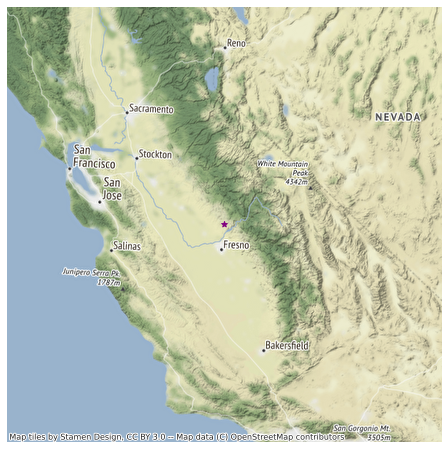

In [15]:
f, ax = plt.subplots(figsize=(8, 8))

sjer_aoi.centroid.plot(ax=ax,
                       color="purple",
                       marker="*")
sjer_aoi.buffer(300000).plot(ax=ax,
                             color="none",
                             edgecolor="none")
cx.add_basemap(ax,
               # source=cx.providers.CartoDB.Voyager,
               crs=sjer_aoi.crs.to_string(),
               interpolation='sinc')

ax.set_axis_off()

In [16]:
# Notice that this image is m uch brighter plotted up here. it's because of
# state_boundary_us_chm.plot but i'm not sure why that is causing an issue

# fig, ax = plt.subplots(figsize=(10, 10))

# # Load the tile raster (note the re-arrangement of the bounds)
# bb = calir.bounds
# # print(bb)
# ax.imshow(es.bytescale(calir.read())[:3].transpose([1, 2, 0]),
#           extent=(bb.left, bb.right, bb.bottom, bb.top),
#           interpolation='sinc')

# sjer_aoi_ll.centroid.plot(ax=ax, markersize=50, color='r')
# ax.set_axis_off()
# plt.show()
#SJER_chm_gpd.plot(ax=ax, markersize=50, color='r')

## Study Area Plots

At this study site, we have both lidar data - specifically a canopy height model
that was processed by NEON (National Ecological Observatory Network). We also
have some "ground truth" data. That is we have measured tree height values collected
at a set of field site plots by technicians at NEON. We will call these measured
values *in situ* measurements.

A map of our study plots is below overlaid on top of the canopy height model.

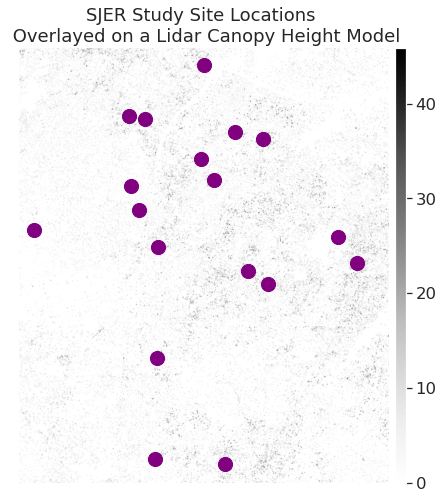

In [17]:
sjer_chm_path = os.path.join("spatial-vector-lidar",
                             "california",
                             "neon-sjer-site", "2013",
                             "lidar",
                             "SJER_lidarCHM.tif")

sjer_chm = rxr.open_rasterio(sjer_chm_path, masked=True)
# with rio.open(sjer_chm_path) as src:
#     sjer_chm = src.read(masked=True)

fig, ax = plt.subplots(figsize=(8, 8))
ep.plot_bands(sjer_chm,
              cmap='Greys',
              extent=plotting_extent(sjer_chm_data,
                                     sjer_chm_data.rio.transform()),
              ax=ax,
              title="SJER Study Site Locations \n Overlayed on a Lidar Canopy Height Model")

SJER_plots.centroid.plot(ax=ax,
                         markersize=200,
                         color='purple')
ax.set_axis_off()

### Compare Lidar Derived Height to In Situ Measurements

We can compare maximum tree height values at each plot to the maximum pixel value
in our `CHM` for each plot. To do this, we define the geographic boundary of our plot
using a polygon - in the case below we use a circle as the boundary. We then extract
the raster cell values for each circle and calculate the max value for all of the
pixels that fall within the plot area.

Then, we calculate the max height of our measured plot tree height data.

Finally we compare the two using a scatter plot to see how closely the data relate.
Do they follow a 1:1 line? Do the data diverge from a 1:1 relationship?

<figure>
    <a href="{{ site.url }}/images/earth-analytics/spatial-data/buffer-circular.png">
    <img src="{{ site.url }}/images/earth-analytics/spatial-data/buffer-circular.png" alt="Circular fuffer."></a>
    <figcaption>In Python, you can use the buffer function to specify a circular buffer radius around an x,y point location. Then, you can use the zonal_stats function to extract the values for all pixels in the specified raster that fall within that circular buffer. In this case, you can tell Python to extract the maximum value of all pixels in the circular buffer. Source: Colin Williams, NEON
    </figcaption>
</figure>


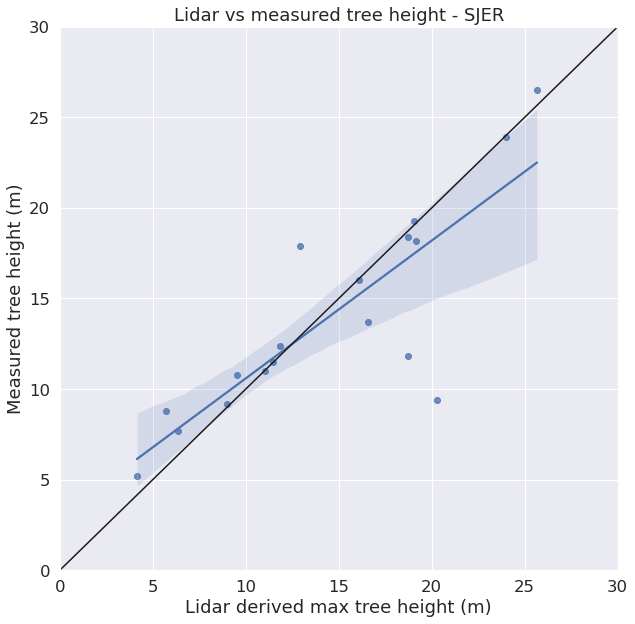

In [18]:
# This plot should show the same with a regression line
fig, ax = plt.subplots(figsize=(10, 10))

#csfont = {'fontname': 'Myriad Pro'}
ax = sns.regplot('max', 'insitu_maxht', data=SJER_final_height)
ax.set(title="Lidar vs measured tree height - SJER")

# Add a 1/1 line
ax.plot((0, 1), (0, 1), 'k-', transform=ax.transAxes)

ax.set(xlabel="Lidar derived max tree height (m)",
       ylabel="Measured tree height (m)")

ax.set_ylim([0, 30])
ax.set_xlim([0, 30])
plt.show()



### How different are the data?




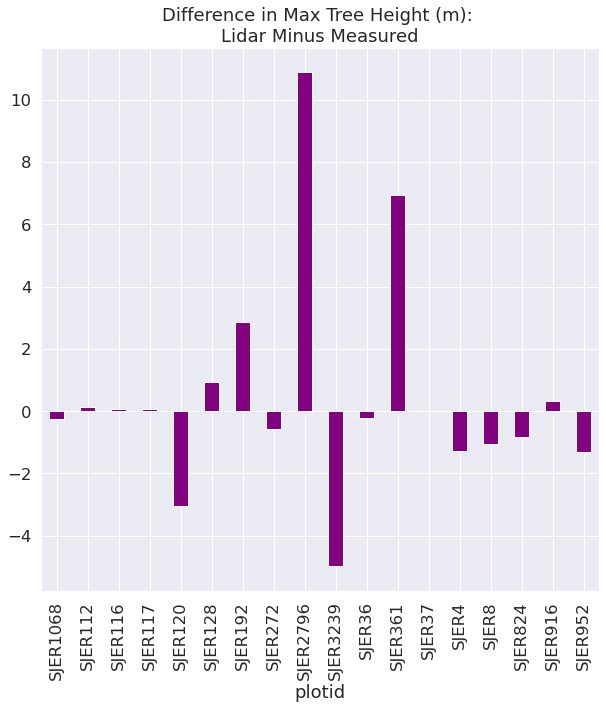

In [19]:
# Calculate difference
# need to add the plot id to each xaxis label
# probably should use matplotlib to create this plot or seaborn??
SJER_final_height["lidar_measured"] = SJER_final_height["max"] - \
    SJER_final_height["insitu_maxht"]

fig, ax = plt.subplots(figsize=(10, 10))
SJER_final_height.plot(x="plotid",
                       y="lidar_measured",
                       kind="bar",
                       color="purple",
                       ax=ax,
                       legend=False)
ax.set_title("Difference in Max Tree Height (m): \nLidar Minus Measured")
plt.show()

## View interactive scatterplot

<a href="https://plot.ly/~leahawasser/170/" target="_blank">View scatterplot plotly</a>



## View interactive difference barplot

<a href="https://plot.ly/~leahawasser/158/chm-minus-insitu-differences/" target="_blank">View scatterplot differences</a>




In [20]:
# python has a plotly api too!
# this cell should be hidden